## To do list:

* Run model without soil moisture or bulk EC (this will add Shale Hills data to the model)
* There is a very strange error in the code where the depth column in df_out can't be accessed via slicing with ==, but it can be accessed by slicing with >= or <=. When I first made the code it ran fine, but upon restarting I can't get the == slicing to work. I APPEAR TO HAVE FIXED THIS PROBLEM BY GETTING DEPTH A DIFFERENT WAY, BUT I STILL DON'T KNOW WHY IT DIDN'T WORK IN THE FIRST PLACE
* Nearest neighbors interpolation takes a really long time (ran it overnight and it didn't finish), so I'm going to try and parallelize

## Possible ways to improve model performance

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 2, 
            'Catalina-Jemez': 1, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
#For the nearest neighbors model, run this cell and all subsequent cells

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df=df.dropna()
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
6794,13570.0000,1.459382e+18,0.0,0.358000,0.044000,16.705000,19.413019,0.0,50.0,0.0,1.0
6795,13830.0000,1.459386e+18,0.0,0.358000,0.044000,16.770000,19.417373,0.0,50.0,0.0,1.0
6796,14100.0000,1.459390e+18,0.0,0.358000,0.044000,16.835000,19.421726,0.0,50.0,0.0,1.0
6797,14315.0000,1.459393e+18,0.0,0.358000,0.044000,16.890000,19.425410,0.0,50.0,0.0,1.0
6798,14515.0000,1.459397e+18,0.0,0.358000,0.044000,16.940000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1357397,17283.8575,1.378375e+18,0.0,0.206000,0.118333,14.052648,12.242505,16.0,60.0,1.0,3.0
1357398,17157.5350,1.378379e+18,0.0,0.205333,0.116667,14.057570,12.195345,16.0,60.0,1.0,3.0
1357399,17048.8825,1.378382e+18,0.0,0.205500,0.115000,14.036808,12.112427,16.0,60.0,1.0,3.0
1357400,16947.1550,1.378386e+18,0.0,0.201400,0.116667,14.015850,11.981998,16.0,60.0,1.0,3.0


In [7]:
#Model Comparison code starts below. Only cells 1-7 (except 5) need to be run in order to start the model comparison section.

In [8]:
#Start of model comparison code

df['SoilMoisture_t_1']=df.SoilMoisture

df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season,SoilMoisture_t_1
6794,13570.0000,1.459382e+18,0.0,0.358000,0.044000,16.705000,19.413019,0.0,50.0,0.0,1.0,0.358000
6795,13830.0000,1.459386e+18,0.0,0.358000,0.044000,16.770000,19.417373,0.0,50.0,0.0,1.0,0.358000
6796,14100.0000,1.459390e+18,0.0,0.358000,0.044000,16.835000,19.421726,0.0,50.0,0.0,1.0,0.358000
6797,14315.0000,1.459393e+18,0.0,0.358000,0.044000,16.890000,19.425410,0.0,50.0,0.0,1.0,0.358000
6798,14515.0000,1.459397e+18,0.0,0.358000,0.044000,16.940000,19.428758,0.0,50.0,0.0,1.0,0.358000
...,...,...,...,...,...,...,...,...,...,...,...,...
1357397,17283.8575,1.378375e+18,0.0,0.206000,0.118333,14.052648,12.242505,16.0,60.0,1.0,3.0,0.206000
1357398,17157.5350,1.378379e+18,0.0,0.205333,0.116667,14.057570,12.195345,16.0,60.0,1.0,3.0,0.205333
1357399,17048.8825,1.378382e+18,0.0,0.205500,0.115000,14.036808,12.112427,16.0,60.0,1.0,3.0,0.205500
1357400,16947.1550,1.378386e+18,0.0,0.201400,0.116667,14.015850,11.981998,16.0,60.0,1.0,3.0,0.201400


0.01938328180555862


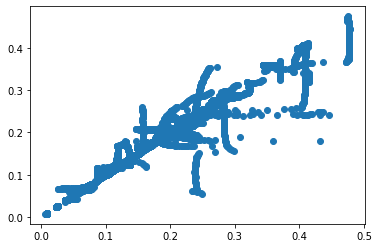

In [9]:
#Run this for systematically missing values
from sklearn import metrics

df_nan=df.copy(deep=True)
df_nan.SoilMoisture.loc[6900:7100]=np.nan
df_nan.SoilMoisture.loc[13500:13700]=np.nan
df_nan.SoilMoisture.loc[20000:20200]=np.nan
df_nan.SoilMoisture.loc[30000:30200]=np.nan
df_nan.SoilMoisture.loc[40000:40200]=np.nan
df_nan.SoilMoisture.loc[50000:50200]=np.nan
df_nan.SoilMoisture.loc[60000:60200]=np.nan
df_nan.SoilMoisture.loc[70000:70200]=np.nan
df_nan.SoilMoisture.loc[80000:80200]=np.nan
df_nan.SoilMoisture.loc[90000:90200]=np.nan
df_nan.SoilMoisture.loc[100000:100200]=np.nan
df_nan.SoilMoisture.loc[110000:110200]=np.nan
df_nan.SoilMoisture.loc[120000:120200]=np.nan
df_nan.SoilMoisture.loc[130000:130200]=np.nan
df_nan.SoilMoisture.loc[140000:140200]=np.nan
df_nan.SoilMoisture.loc[150000:150200]=np.nan
df_nan.SoilMoisture.loc[160000:160200]=np.nan
df_nan.SoilMoisture.loc[170000:170200]=np.nan
df_nan.SoilMoisture.loc[180000:180200]=np.nan
df_nan.SoilMoisture.loc[190000:190200]=np.nan
df_nan.SoilMoisture.loc[200000:200200]=np.nan
df_nan.SoilMoisture.loc[210000:210200]=np.nan
df_nan.SoilMoisture.loc[220000:220200]=np.nan
df_nan.SoilMoisture.loc[230000:230200]=np.nan
df_nan.SoilMoisture.loc[240000:240200]=np.nan
df_nan.SoilMoisture.loc[250000:250200]=np.nan
df_nan.SoilMoisture.loc[260000:260200]=np.nan
df_nan.SoilMoisture.loc[270000:270200]=np.nan
df_nan.SoilMoisture.loc[280000:280200]=np.nan
df_nan.SoilMoisture.loc[290000:290200]=np.nan
df_nan.SoilMoisture.loc[310000:310200]=np.nan
df_nan.SoilMoisture.loc[320000:320200]=np.nan
df_nan.SoilMoisture.loc[330000:330200]=np.nan
df_nan.SoilMoisture.loc[340000:340200]=np.nan
df_nan.SoilMoisture.loc[350000:350200]=np.nan
df_nan.SoilMoisture.loc[360000:360200]=np.nan
df_nan.SoilMoisture.loc[370000:370200]=np.nan
df_nan.SoilMoisture.loc[380000:380200]=np.nan
df_nan.SoilMoisture.loc[390000:390200]=np.nan
df_nan.SoilMoisture.loc[400000:400200]=np.nan
df_nan.SoilMoisture.loc[410000:410200]=np.nan
df_nan.SoilMoisture.loc[420000:420200]=np.nan
df_nan.SoilMoisture.loc[430000:430200]=np.nan
df_nan.SoilMoisture.loc[440000:440200]=np.nan
df_nan.SoilMoisture.loc[450000:450200]=np.nan
df_nan.SoilMoisture.loc[460000:460200]=np.nan
df_nan.SoilMoisture.loc[470000:470200]=np.nan
df_nan.SoilMoisture.loc[480000:480200]=np.nan
df_nan.SoilMoisture.loc[490000:490200]=np.nan
df_nan.SoilMoisture.loc[500000:500200]=np.nan
df_nan.SoilMoisture.loc[510000:510200]=np.nan
df_nan.SoilMoisture.loc[520000:520200]=np.nan
df_nan.SoilMoisture.loc[530000:530200]=np.nan
df_nan.SoilMoisture.loc[540000:540200]=np.nan
df_nan.SoilMoisture.loc[550000:550200]=np.nan
df_nan.SoilMoisture.loc[560000:560200]=np.nan
df_nan.SoilMoisture.loc[570000:570200]=np.nan
df_nan.SoilMoisture.loc[580000:580200]=np.nan
df_nan.SoilMoisture.loc[590000:590200]=np.nan
df_nan.SoilMoisture.loc[600000:600200]=np.nan
df_nan.SoilMoisture.loc[610000:610200]=np.nan
df_nan.SoilMoisture.loc[620000:620200]=np.nan
df_nan.SoilMoisture.loc[630000:630200]=np.nan
df_nan.SoilMoisture.loc[640000:640200]=np.nan
df_nan.SoilMoisture.loc[650000:650200]=np.nan
df_nan.SoilMoisture.loc[660000:660200]=np.nan
df_nan.SoilMoisture.loc[670000:670200]=np.nan
df_nan.SoilMoisture.loc[680000:680200]=np.nan
df_nan.SoilMoisture.loc[690000:690200]=np.nan
df_nan.SoilMoisture.loc[700000:700200]=np.nan
df_nan.SoilMoisture.loc[710000:710200]=np.nan
df_nan.SoilMoisture.loc[720000:720200]=np.nan
df_nan.SoilMoisture.loc[730000:730200]=np.nan
df_nan.SoilMoisture.loc[740000:740200]=np.nan
df_nan.SoilMoisture.loc[750000:750200]=np.nan
df_nan.SoilMoisture.loc[760000:760200]=np.nan
df_nan.SoilMoisture.loc[770000:770200]=np.nan
df_nan.SoilMoisture.loc[780000:780200]=np.nan
df_nan.SoilMoisture.loc[790000:790200]=np.nan
df_nan.SoilMoisture.loc[810000:810200]=np.nan
df_nan.SoilMoisture.loc[820000:820200]=np.nan
df_nan.SoilMoisture.loc[830000:830200]=np.nan
df_nan.SoilMoisture.loc[840000:840200]=np.nan
df_nan.SoilMoisture.loc[850000:850200]=np.nan
df_nan.SoilMoisture.loc[860000:860200]=np.nan
df_nan.SoilMoisture.loc[870000:870200]=np.nan
df_nan.SoilMoisture.loc[880000:880200]=np.nan
df_nan.SoilMoisture.loc[890000:890200]=np.nan
df_nan.SoilMoisture.loc[900000:900200]=np.nan
df_nan.SoilMoisture.loc[910000:910200]=np.nan
df_nan.SoilMoisture.loc[920000:920200]=np.nan
df_nan.SoilMoisture.loc[930000:930200]=np.nan
df_nan.SoilMoisture.loc[940000:940200]=np.nan
df_nan.SoilMoisture.loc[950000:950200]=np.nan
df_nan.SoilMoisture.loc[960000:960200]=np.nan
df_nan.SoilMoisture.loc[970000:970200]=np.nan
df_nan.SoilMoisture.loc[980000:980200]=np.nan
df_nan.SoilMoisture.loc[990000:990200]=np.nan
df_nan.SoilMoisture.loc[1000000:1000200]=np.nan
df_nan.SoilMoisture.loc[1010000:1010200]=np.nan
df_nan.SoilMoisture.loc[1020000:1020200]=np.nan
df_nan.SoilMoisture.loc[1030000:1030200]=np.nan
df_nan.SoilMoisture.loc[1040000:1040200]=np.nan
df_nan.SoilMoisture.loc[1050000:1050200]=np.nan
df_nan.SoilMoisture.loc[1060000:1060200]=np.nan
df_nan.SoilMoisture.loc[1070000:1070200]=np.nan
df_nan.SoilMoisture.loc[1080000:1080200]=np.nan
df_nan.SoilMoisture.loc[1090000:1090200]=np.nan
df_nan.SoilMoisture.loc[1100000:1100200]=np.nan
df_nan.SoilMoisture.loc[1110000:1110200]=np.nan
df_nan.SoilMoisture.loc[1120000:1120200]=np.nan
df_nan.SoilMoisture.loc[1130000:1130200]=np.nan
df_nan.SoilMoisture.loc[1140000:1140200]=np.nan
df_nan.SoilMoisture.loc[1150000:1150200]=np.nan
df_nan.SoilMoisture.loc[1160000:1160200]=np.nan
df_nan.SoilMoisture.loc[1170000:1170200]=np.nan
df_nan.SoilMoisture.loc[1180000:1180200]=np.nan
df_nan.SoilMoisture.loc[1190000:1190200]=np.nan
df_nan.SoilMoisture.loc[1200000:1200200]=np.nan
df_nan.SoilMoisture.loc[1210000:1210200]=np.nan
df_nan.SoilMoisture.loc[1220000:1220200]=np.nan
df_nan.SoilMoisture.loc[1230000:1230200]=np.nan
df_nan.SoilMoisture.loc[1240000:1240200]=np.nan
df_nan.SoilMoisture.loc[1250000:1250200]=np.nan
df_nan.SoilMoisture.loc[1260000:1260200]=np.nan
df_nan.SoilMoisture.loc[1270000:1270200]=np.nan
df_nan.SoilMoisture.loc[1280000:1280200]=np.nan
df_nan.SoilMoisture.loc[1290000:1290200]=np.nan
df_nan.SoilMoisture.loc[1300000:1300200]=np.nan
df_nan.SoilMoisture.loc[1310000:1310200]=np.nan
df_nan.SoilMoisture.loc[1320000:1320200]=np.nan
df_nan.SoilMoisture.loc[1330000:1330200]=np.nan
df_nan.SoilMoisture.loc[1340000:1340200]=np.nan
df_nan.SoilMoisture.loc[1350000:1350200]=np.nan
df_nan.SoilMoisture.loc[1360000:1360200]=np.nan
df_nan.SoilMoisture.loc[1370000:1370200]=np.nan
df_nan.SoilMoisture.loc[1380000:1380200]=np.nan
df_nan.SoilMoisture.loc[1390000:1390200]=np.nan
#df_nan.SoilMoisture.loc[df_nan.sample(frac=0.5).index] = np.nan



nan_index=df_nan[df_nan.SoilMoisture.notna()==False]
not_nan_index=df_nan[df_nan.SoilMoisture.notna()==True]
df_nan['SoilMoisture_t_1'].loc[nan_index.index]=np.nan
df_nan['SoilMoisture_t_1']=df_nan['SoilMoisture_t_1'].shift(1)
df_nan['SoilMoisture_t_1'][1]=.358

df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.SoilMoisture=df_nan_median.SoilMoisture.fillna(np.nanmedian(df_nan_median.SoilMoisture))


df_nan_linear=df_nan_linear.interpolate()

df_nan_linear.SoilMoisture=df_nan_linear.SoilMoisture.fillna(np.nanmedian(df_nan_linear.SoilMoisture))
df_nan_linear.SoilMoisture_t_1=df_nan_linear.SoilMoisture_t_1.fillna(np.nanmedian(df_nan_linear.SoilMoisture_t_1))


print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))
plt.scatter(df.SoilMoisture.loc[nan_index.index], df_nan_linear.SoilMoisture.loc[nan_index.index])


In [10]:
#Run this to train the model on whatever not_nan_index you have defined

df_st =  StandardScaler().fit_transform(df_nan_linear.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture2']
X_t1=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'SoilMoisture2', 'Pit', 'Site', 'timestamp']]
y_t1=df_st1['SoilMoisture']  # Labels\n",

X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'timestamp', 'Pit', 'Site']]
y=df_st1['SoilMoisture']  # Labels\n",

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99)
X_train_t1, X_test_t1, y_train_t1, y_test_t1 = train_test_split(X_t1, y_t1, train_size=0.99)


from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
print(neigh.score(X_test,y_test))

neigh_t1 = KNeighborsRegressor(n_neighbors=2)
neigh_t1.fit(X_train_t1, y_train_t1)
print (neigh_t1.score(X_test_t1,y_test_t1))

0.9976961339029058
0.9913846067110552


In [11]:
st_nan=  StandardScaler().fit_transform(df_nan_linear.loc[nan_index.index])
df_st_nan=pd.DataFrame(data=st_nan)
df_st_nan_t1=pd.DataFrame(data=st_nan)

df_st_nan.index=nan_index.index
df_st_nan_t1.index=nan_index.index


df_st_nan.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture_t_1']
X_nan=df_st_nan[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'timestamp', 'Pit', 'Site']]  # Features\n",
y_nan=df_st_nan['SoilMoisture']  # Labels\n",

df_st_nan_t1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture_t_1']
#df_st_nan_t1['SoilMoisture_t_1']=df_st_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_st_nan_t1['SoilMoisture_t_1']))
X_nan_t1=df_st_nan_t1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'SoilMoisture_t_1', 'Pit', 'Site', 'timestamp']]  # Features\n",
y_nan_t1=df_st_nan_t1['SoilMoisture']  # Labels\n",

X_nan_t1['SoilMoisture_t_1']=X_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_nan_linear['SoilMoisture_t_1']))

SM_predict=neigh.predict(X_nan)
SM_predict_df=pd.DataFrame(data=SM_predict)
SM_predict_df.index=nan_index.index

SM_predict_t1=neigh_t1.predict(X_nan_t1)
SM_predict_t1_df=pd.DataFrame(data=SM_predict_t1)
SM_predict_t1_df.index=nan_index.index



<ipython-input-11-e5fceb340a9d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nan_t1['SoilMoisture_t_1']=X_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_nan_linear['SoilMoisture_t_1']))


In [12]:
SM_predict_original=SM_predict_df*np.std(df_nan_linear['SoilMoisture'])+np.mean(df_nan_linear.SoilMoisture)

SM_predict_original_t1=SM_predict_t1_df*np.std(df_nan_linear['SoilMoisture'])+np.mean(df_nan_linear.SoilMoisture)
nan_index
df_nan_linear['SoilMoisture'].loc[nan_index.index]

6900       0.359995
6901       0.359990
6902       0.359985
6903       0.359980
6904       0.359975
             ...   
1350196    0.197427
1350197    0.197475
1350198    0.197523
1350199    0.197571
1350200    0.197619
Name: SoilMoisture, Length: 16809, dtype: float64

In [13]:
a=df.SoilMoisture.loc[nan_index.index]
b=SM_predict_original
c=SM_predict_original_t1
d=df_nan_linear.SoilMoisture.loc[nan_index.index]
e=df_nan_median.SoilMoisture.loc[nan_index.index]
print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))

print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))
print('kNN with lag RMSE:', metrics.mean_squared_error(a, c, squared=False))
print('Linear RMSE:', metrics.mean_squared_error(a, d, squared=False))
print('Median RMSE:', metrics.mean_squared_error(a, e, squared=False))


print(metrics.max_error(a, b))
print(metrics.max_error(a, c))
print(metrics.max_error(a, d))

print(metrics.mean_absolute_error(a, b))
print(metrics.mean_absolute_error(a, c))
print(metrics.mean_absolute_error(a, d))
print(metrics.mean_absolute_error(a, e))



print(np.var(df.SoilMoisture))





0.01938328180555862
kNN without lag RMSE: 0.028691274462098428
kNN with lag RMSE: 0.023288080752579095
Linear RMSE: 0.01938328180555862
Median RMSE: 0.0943123755732353
0.4859798935693104
0.20688323699039793
0.2520123762376238
0.014653905928708041
0.010850912068037956
0.0070848354376541675
0.07421713194320503
0.007892823381030773


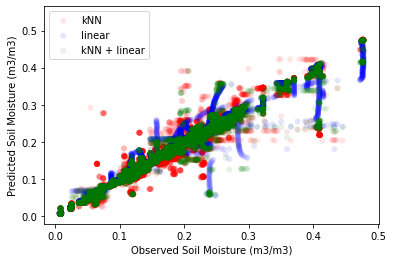

In [14]:
#print(metrics.mean_squared_error(ab, bc, squared=False))
#plt.scatter(a, b)


fig, ax = plt.subplots()

ax.scatter(a, b, c='r', label='kNN',
               alpha=0.1, edgecolors='none')

ax.scatter(a, d, c='b', label='linear',
               alpha=0.1, edgecolors='none')
ax.scatter(a, c, c='g', label='kNN + linear',
               alpha=0.1, edgecolors='none')
#ax.scatter(a, e, c='g', label='kNN with lag',
               #alpha=0.3, edgecolors='none')
ax.legend(loc=2)
ax.set_xlabel('Observed Soil Moisture (m3/m3)')
ax.set_ylabel('Predicted Soil Moisture (m3/m3)')
#ax.set_title('Observed vs predicted soil moi')
plt.show()
#plt.scatter(a,d)
#plt.scatter(a,c)
#plt.scatter(a,b)

In [15]:
import hydroeval as he


print( he.evaluator(he.nse, a, b))
print( he.evaluator(he.nse, a, c))
print( he.evaluator(he.nse, a, d))




[0.90179557]
[0.93361122]
[0.95380909]


In [16]:
from sklearn.metrics import r2_score
print (r2_score(a, b))
print (r2_score(a, c))
print (r2_score(a, d))
nan_index

0.9071415568825634
0.9388228677969274
0.9576184986230442


,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season,SoilMoisture_t_1
6900,17080.00000,1.459764e+18,0.82,NaN,0.045000,17.78000,19.611429,0.0,50.0,0.0,2.0,0.3600
6901,17025.00000,1.459768e+18,0.82,NaN,0.045000,17.71500,19.726784,0.0,50.0,0.0,2.0,0.3600
6902,16830.00000,1.459771e+18,4.05,NaN,0.045000,17.67500,19.673080,0.0,50.0,0.0,2.0,0.3600
6903,16875.00000,1.459775e+18,4.05,NaN,0.045000,17.63000,19.543688,0.0,50.0,0.0,2.0,0.3595
6904,16720.00000,1.459778e+18,4.05,NaN,0.045000,17.57500,19.462423,0.0,50.0,0.0,2.0,0.3590
...,...,...,...,...,...,...,...,...,...,...,...,...
1350196,1425.55650,1.489788e+18,0.00,NaN,0.031667,1.36200,13.886000,16.0,10.0,1.0,1.0,0.1990
1350197,1403.00100,1.489792e+18,0.00,NaN,0.033333,1.35850,13.886500,16.0,10.0,1.0,1.0,0.1990
1350198,1369.57675,1.489795e+18,0.00,NaN,0.033333,1.34450,13.887750,16.0,10.0,1.0,1.0,0.1980
1350199,1373.58200,1.489799e+18,0.00,NaN,0.030000,1.33075,13.889500,16.0,10.0,1.0,1.0,0.1980


In [17]:
len(nan_index)/len(df)

0.02007044776119403

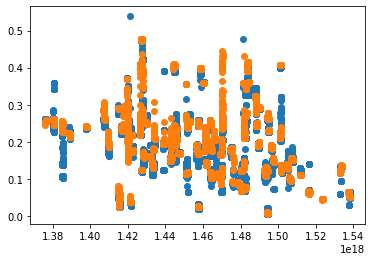

In [18]:
plt.scatter(nan_index.timestamp,b)
plt.scatter(nan_index.timestamp,nan_index.SoilMoisture_t_1)